In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

from rdkit import Chem, DataStructs
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
from rdkit.Chem import AllChem
IPythonConsole.drawOptions.addAtomIndices = True
from rdkit.Chem import Descriptors
from rdkit.Chem import rdFingerprintGenerator
from rdkit.Chem import PandasTools
from rdkit.ML.Descriptors import MoleculeDescriptors

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
from sklearn.metrics import pairwise_distances_argmin_min
import hdbscan

# Load data

In [2]:
df = pd.read_csv('dataset.csv')
df.head()

,Smiles,Source
0,CCOC(=O)C=Cc1cnc[nH]1,Enamine
1,CCOC(=O)C=Cc1cscn1,Enamine
2,COC(=O)c1cccc(c1)c2cnc[nH]2,Enamine
3,c1ccc(cc1)c2ccc(cc2)c3cnc[nH]3,Enamine
4,CCOC(=O)c1cc(n[nH]1)c2cnc[nH]2,Enamine


# Visualize molecules 

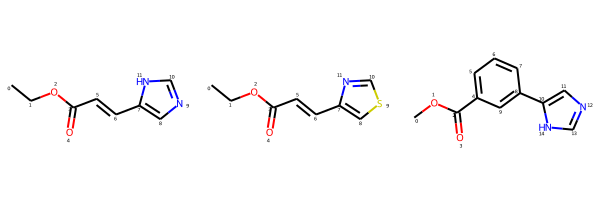

In [3]:
smiles = df.Smiles.head(3)
mols = [Chem.MolFromSmiles(m) for m in smiles]
Draw.MolsToGridImage(mols,molsPerRow=3,subImgSize=(200,200),legends=None)

# Calculate descriptors 

##  Molecular descriptors 

In [4]:
def calc_rdkit_desc(smiles):
    desc_list = [n[0] for n in Descriptors._descList]
    calc = MoleculeDescriptors.MolecularDescriptorCalculator(desc_list)
    rdkit_desc = [calc.CalcDescriptors(Chem.MolFromSmiles(m)) for m in smiles]
    rdkit_desc_df = pd.DataFrame(rdkit_desc, columns=desc_list)
    return rdkit_desc_df

In [5]:
rdkit_desc_df = calc_rdkit_desc(df.Smiles.tolist())
rdkit_desc_df.head()

,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,10.794923,-0.340648,10.794923,0.340648,0.537689,166.180,156.100,166.074228,64,0,...,0,0,0,0,0,0,0,0,0,0
1,10.804844,-0.328241,10.804844,0.328241,0.528764,183.232,174.160,183.035400,64,0,...,0,0,0,0,0,1,0,0,0,0
2,11.287188,-0.336699,11.287188,0.336699,0.756058,202.213,192.133,202.074228,76,0,...,0,0,0,0,0,0,0,0,0,0
3,4.023593,1.045937,4.023593,1.045937,0.699767,220.275,208.179,220.100048,82,0,...,0,0,0,0,0,0,0,0,0,0
4,11.308299,-0.406699,11.308299,0.334676,0.732890,206.205,196.125,206.080376,78,0,...,0,0,0,0,0,0,0,0,0,0


## Molecular fingerprints 

In [6]:
def calc_fp(mols):
    mfp2_fps = rdFingerprintGenerator.GetFPs(mols)
    FPS = []
    
    # Convert fingerprint vectors to numpy arrays
    for fp in mfp2_fps:
        arr = np.zeros((1,))
        DataStructs.ConvertToNumpyArray(fp, arr)
        FPS.append(arr)
        
    col_names=['bit' + str(x) for x in range(len(FPS[0]))]
    fp_df = pd.DataFrame(FPS, columns=col_names)
    return fp_df

In [7]:
PandasTools.AddMoleculeColumnToFrame(df, smilesCol='Smiles')
fp_df = calc_fp(df['ROMol'].tolist())
fp_df.head()

,bit0,bit1,bit2,bit3,bit4,bit5,bit6,bit7,bit8,bit9,...,bit2038,bit2039,bit2040,bit2041,bit2042,bit2043,bit2044,bit2045,bit2046,bit2047
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
df_all = fp_df.join(rdkit_desc_df)
df_all.head()

,bit0,bit1,bit2,bit3,bit4,bit5,bit6,bit7,bit8,bit9,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,1,0,0,0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


# Dimensionality reduction

## PCA 

In [9]:
pca = PCA(800)
scaler = StandardScaler()

# Get the first nth PCs

X = df_all
X_scaled = scaler.fit_transform(X)
X_pca = pca.fit_transform(X_scaled)

df_pca = pd.DataFrame({'PC1': X_pca[:,0], 'PC2': X_pca[:,1]})

0.03 variance explained by the first two PCs.
0.96 variance explained overall.


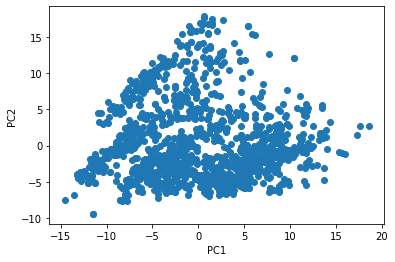

In [10]:
# Plot the first two PCs and calculate variance explained

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.scatter(x=X_pca[:,0], y=X_pca[:,1])
print('{} variance explained by the first two PCs.'.format(round(pca.explained_variance_ratio_[0:2].sum(),2)))
print('{} variance explained overall.'.format(round(pca.explained_variance_ratio_.sum(),2)))

In [11]:
df_pca_importance = pd.DataFrame({'features': X.columns, 'PC1_importance': pca.components_[0,:], 
                                  'PC2_importance': pca.components_[1,:]})

df_pca_importance.to_csv('PCA_importance.csv', index=False)
print('PC1 importance:\n', df_pca_importance.sort_values('PC1_importance', ascending=False).head(10))
print('PC2 importance:\n', df_pca_importance.sort_values('PC2_importance', ascending=False).head(10))

PC1 importance:
                  features  PC1_importance  PC2_importance
2078                 Chi1        0.142207        0.054692
2152       HeavyAtomCount        0.141406        0.060798
2056  NumValenceElectrons        0.137981        0.080251
2075                 Chi0        0.136958        0.073569
2076                Chi0n        0.134928        0.071709
2079                Chi1n        0.133609        0.063582
2092            LabuteASA        0.133500        0.055864
2170                MolMR        0.128829        0.034688
2052                  qed        0.127325        0.010184
2074              BertzCT        0.123561        0.002673
PC2 importance:
                  features  PC1_importance  PC2_importance
2181               fr_C_O       -0.024115        0.151466
2182         fr_C_O_noCOO       -0.024115        0.151466
650                bit650       -0.024570        0.149510
1917              bit1917       -0.024520        0.132714
2124           SlogP_VSA5       -0.014

## t-SNE 

Text(0, 0.5, 'TSNE2')

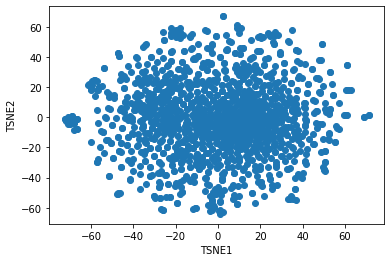

In [12]:
tsne= TSNE(n_components=2)
X_tsne = tsne.fit_transform(X_pca)
plt.scatter(x=X_tsne[:,0], y=X_tsne[:,1]);
plt.xlabel('TSNE1')
plt.ylabel('TSNE2')

# Clustering

## HDBSCAN

In [13]:
hdb = hdbscan.HDBSCAN(min_cluster_size=2)
hdb_y_pred = hdb.fit_predict(X_pca)

# Show number of clusters by HDBSCAN

hdb_clusters = pd.Categorical(hdb_y_pred)
hdb_clusters

[122, 112, -1, -1, 4, ..., 23, -1, 166, -1, -1]
Length: 1427
Categories (275, int64): [-1, 0, 1, 2, ..., 270, 271, 272, 273]

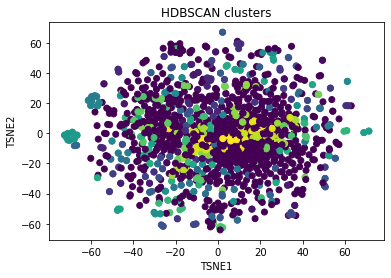

In [14]:
# Visualize clustering results

plt.xlabel('TSNE1')
plt.ylabel('TSNE2')
plt.title('HDBSCAN clusters')
plt.scatter(x=X_tsne[:,0], y=X_tsne[:,1], c=hdb_y_pred);

## K-Means

### Find optimal k 

In [15]:
X = X_tsne
metric = 'euclidean'
k_clusters = []
distortions = []
inertias = []
s_scores = []
K = range(1, 1001)
  
for k in K:
    if k % 50 == 0:
        k_clusters.append(k)
        k_means = KMeans(n_clusters=k).fit(X)
        k_means.fit(X)
        labels = k_means.labels_
        
        # Calculate distortion, intertia, silhouette scores every 50th k
        distortions.append(sum(np.min(cdist(X, k_means.cluster_centers_,metric), axis=1)) / X.shape[0])
        inertias.append(k_means.inertia_)
        s_scores.append(metrics.silhouette_score(X, labels, metric=metric))

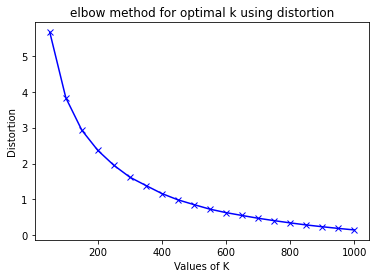

In [16]:
plt.plot(k_clusters, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('elbow method for optimal k using distortion')
plt.show()

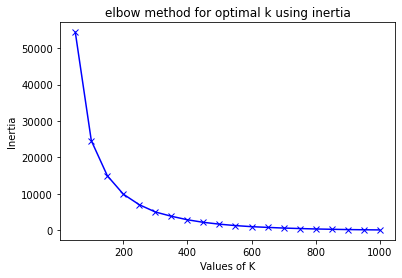

In [17]:
plt.plot(k_clusters, inertias, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('elbow method for optimal k using inertia')
plt.show()

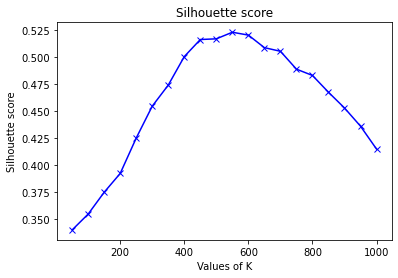

In [18]:
plt.plot(k_clusters, s_scores, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Silhouette score')
plt.title('Silhouette score')
plt.show()

### Set k=96 based on experimental bandwidth

In [19]:
k_means = KMeans(n_clusters=96, init='random', n_init=10)
kmeans_y_pred = k_means.fit_predict(X)
labels = k_means.labels_
s_score = metrics.silhouette_score(X, labels, metric=metric)
s_score

0.34211475

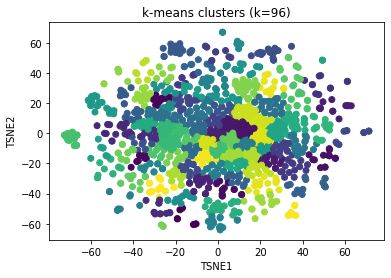

In [20]:
# Visualize clustering results 

plt.xlabel('TSNE1')
plt.ylabel('TSNE2')
plt.title('k-means clusters (k=96)')
plt.scatter(x=X_tsne[:,0], y=X_tsne[:,1], c=kmeans_y_pred);

### Select ligands

In [21]:
df_all_clusters = pd.DataFrame({'Smiles': df.Smiles,
                                'TSNE1': X_tsne[:,0], 'TSNE2': X_tsne[:,1],
                                'PC1': X_pca[:,0], 'PC2': X_pca[:,1],
                                'HDBSCANCluster': hdb_y_pred, 
                                'KMeansCluster': kmeans_y_pred}
                              )

df_all_clusters

,Smiles,TSNE1,TSNE2,PC1,PC2,HDBSCANCluster,KMeansCluster
0,CCOC(=O)C=Cc1cnc[nH]1,-61.345818,21.673155,-1.276586,6.050408,122,51
1,CCOC(=O)C=Cc1cscn1,-58.219173,24.935123,-5.212284,9.965326,112,51
2,COC(=O)c1cccc(c1)c2cnc[nH]2,5.079420,6.210107,7.355218,3.749815,-1,6
3,c1ccc(cc1)c2ccc(cc2)c3cnc[nH]3,6.337606,-6.660830,11.753605,-5.385927,-1,73
4,CCOC(=O)c1cc(n[nH]1)c2cnc[nH]2,3.725018,26.283510,6.769265,6.679348,4,49
...,...,...,...,...,...,...,...
1422,CC1(CO1)c2cocn2,-45.999557,-33.122314,-7.546733,2.769641,23,72
1423,COC(=O)c1scc2[nH]cnc12,33.236984,17.152739,-0.981190,4.828581,-1,68
1424,Clc1cncs1,-56.997261,-29.441113,-12.009613,-5.206074,166,61
1425,COC1CN(Cc2cncs2)CCC1C,49.646961,20.844652,3.853440,14.108122,-1,8


In [22]:
# Select ligands closest to the centroid of each cluster

selected_ligands = []
for n in range(96):
    members = df_all_clusters[df_all_clusters['KMeansCluster'] == n].index.tolist()
    selected_ligands.append(members[pairwise_distances_argmin_min(k_means.cluster_centers_, X_tsne[members,:])[0][n]])

In [23]:
for i in selected_ligands:
    df_all_clusters.at[i, 'Centroid'] = 'Yes'

df_all_clusters.Centroid.fillna('No', inplace=True)    

In [24]:
df_all_clusters.groupby('Centroid').count()

,Smiles,TSNE1,TSNE2,PC1,PC2,HDBSCANCluster,KMeansCluster
Centroid,,,,,,,
No,1331,1331,1331,1331,1331,1331,1331
Yes,96,96,96,96,96,96,96


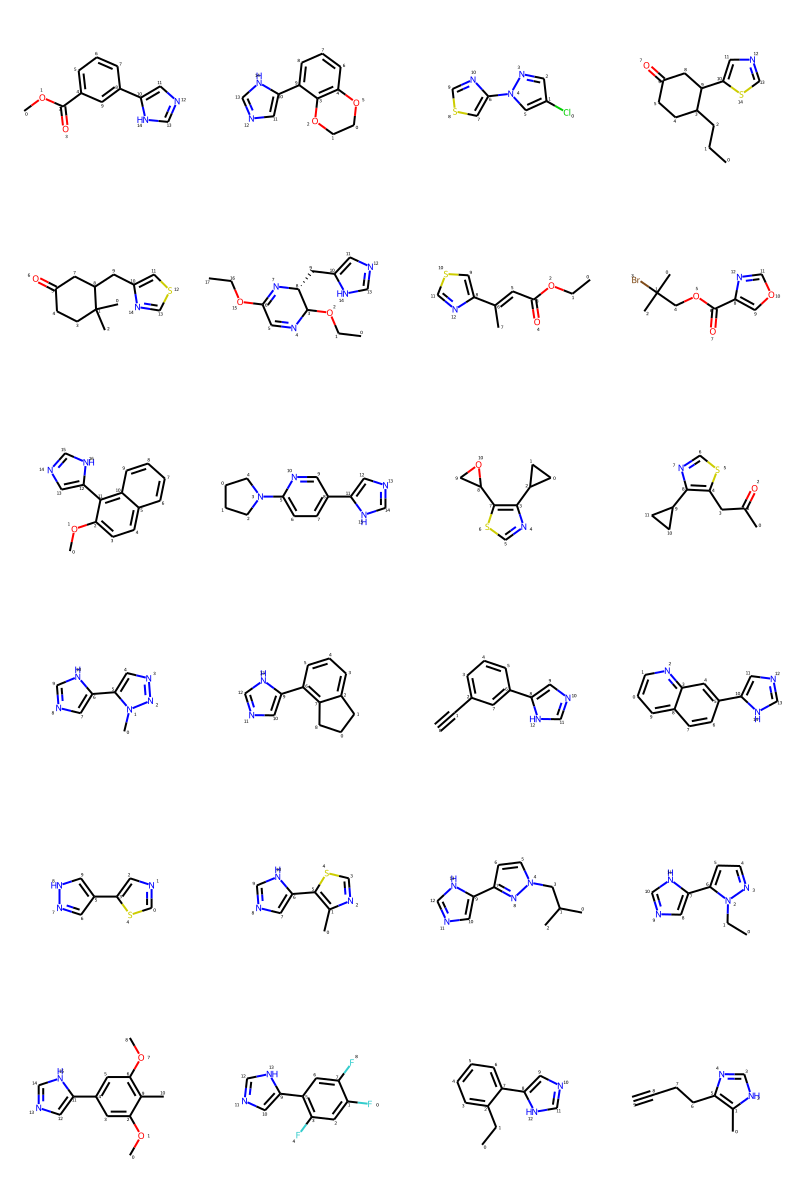

In [26]:
smiles = df_all_clusters.loc[df_all_clusters['Centroid']=='Yes'].Smiles.head(24)
mols = [Chem.MolFromSmiles(m) for m in smiles]
Draw.MolsToGridImage(mols,molsPerRow=4,subImgSize=(200,200),legends=None)